# Simple Reinforcement Learning With Python

In this notebook we start with a very simple RL example and solve a simple problem from the Open AI GYM using Q leanring and random action. 
You will need gym, numpy, random, time, matplotlib, and tqdm (optional).

You can install in a new cell here:

!pip install gym==0.7.4

https://pypi.org/project/gym/0.7.4/

https://github.com/openai/gym



## Goals: 
By the end of this notebook, the key concepts to learn are the parameters that are important for setting up learning algorithms, comparing random trial and error versus simple Q-learning. As we go through, keep track of key lines in the code to identify and explain the role of learning rate, discount, and exploraiton parameters. 

Extra points to whoever can write Q-learning equations on the board, and point where in the code they're implemented :) 

**Cheat sheet: http://incompleteideas.net/book/bookdraft2017nov5.pdf

In [2]:
import gym
import numpy as np
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import pyplot as plt
from tqdm import tqdm

# Using open AI GYM

Here the gol is very simple: create an evironment from the library offered by AI GYM. There are many environments there, and we will use a very simple problem: the taxi problem.


The taxi problem is very inuitive: you are making a self driving taxi in a grid world. You're coding how the taxi will do this!  There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop them off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions. This task was introduced in the paper below to illustrate some issues in hierarchical reinforcement learning:


T Erez, Y Tassa, E Todorov, "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition", 2011.

You can view the AI GYM source code on github:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

Now let's create the taxi environment using the AI GYM (which we imported above). Its dicitonary's structure is very simple:
{action: [(probability, nextstate, reward, done)]}

In [5]:
env= gym.make("Taxi-v2").env

# let's see what's stored 
print(env.P[10])
env.

{0: [(1.0, 110, -1, False)], 1: [(1.0, 10, -1, False)], 2: [(1.0, 30, -1, False)], 3: [(1.0, 10, -1, False)], 4: [(1.0, 10, -10, False)], 5: [(1.0, 10, -10, False)]}


# Seeking rewards by random trial and error
Let's create an infinite loop which runs until one passenger reaches one destination (one episode), i.e. when the received reward is 20.
The env.action_space.sample() method selects one random action from all possible actions.


    Description:
    There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. Once the passenger is dropped off, the episode ends.
    Observations: 
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations. 
    
    Actions: 
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    Rewards: 
    There is a reward of -1 for each action and an additional reward of +20 for delievering the passenger. 
    There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    
    Actions:
    - 0: south
    - 1: north
    - 2: east
    - 3: west
    - 4: pickup
    - 5: dropoff
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)

In [6]:
env= gym.make("Taxi-v2").env
env.s=328

# set number of iterations, penalties and reward to zero
epochs=0
penalties, reward= 0, 0
done=False

while not done:
    # sample a random action
    action=env.action_space.sample()
    # step the agent with that action and collect reward 
    state, reward, done, info = env.step(action)
    # what you got?
    if reward ==-10:
        penalties+=1    
    epochs+=1
    
print("Timesteps/epochs taken: {}".format(epochs))
print("Penalties so far: {}".format(penalties))
    


Timesteps/epochs taken: 256
Penalties so far: 58


Run the code above multiple times. Observe how many timesteps or epochs it takes the taxi to deliver someone with random action. Look at the penalties.

Now let's do the same, but this time save some parameters so we can see what our taxi did!

In [10]:
env= gym.make("Taxi-v2").env
env.s=328

# set number o fiterations, penalties and reward to zero
epochs=0
penalties, reward= 0, 0

frames=[]
done=False

while not done:
    # sample a random action
    action=env.action_space.sample()
    # step the agent with that action and collect reward 
    state, reward, done, info = env.step(action)
    # what you got?
    if reward ==-10:
        penalties+=1
        
    # save each rendered frame into the dicitonary for animaiton
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward':reward
    })
    epochs+=1
    
print("Timesteps/epochs taken: {}".format(epochs))
print("Penalties so far: {}".format(penalties))

    
    
# print all actions, states, rewards
def frames_f(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"timestep: {i+1}")
        print(f"state: {frame['state']}")
        print(f"action: {frame['action']}")
        print(f"reward: {frame['reward']}")
        sleep(.1)
        
print("Watching random action when the goal is so clear is so frustrating...")
frames_f(frames)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

timestep: 1290
state: 16
action: 5
reward: 20


In [4]:
# you can also look into every freeze frame of all the time steps our taxi took
print(frames[1]['frame'].getvalue())

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



# Below is the Q learning algorithm 

Step 1: Initialize the Q-Table with all zeros and Q-Values to arbitrary constants.

Step 2: Let the agent react to the environment and explore the actions. For each change in state, select any one among all possible actions for the current state (S).

Step 3: Travel to the next state (S’) as a result of that action (a).

Step 4: For all possible actions from the state (S’) select the one with the highest Q-value.

Step 5: Update Q-table values using the equation.

State 6: Change the next state as the current state.

Step 7: If goal state is reached, then end and repeat the process.

In [14]:
# Init Taxi-V2 Env
env = gym.make("Taxi-v2").env

# Init q table, arbitrary values
q_tab= np.zeros([env.observation_space.n, env.action_space.n])
print('action space: {}'.format(np.size(q_tab, 1)))
print('observation space: {}'.format(np.size(q_tab, 0)))

# hyper parameters
# workshop:: By the end of this notebook, can you tell what q and these parameters do?
# can 
alpha=.1
gamma=.6
epsilon=.1

all_epochs,all_penalties=[],[]

action space: 6
observation space: 500


# Let's write a smarter action selection function.
It's mostly greedy and wants to get the most reward :)
But with a small probaiblity (epsilon) it will take a random action
This way it has some opportunity to explore
**$ Bonus point $**: when we don't know much, it's useful to explore more. 
When we know more, maybe exploration is not great. Can you write a decaying exploration function?

In [11]:
def select_action(env, epsilon):
    if random.uniform(0,1)<epsilon:
        # explore action space: take random
        action=env.action_space.sample()
    else:
        # check learned q values & take the best action that maximizes reward (greedy!)
        action=np.argmax(q_table[state])
    return action


# Now we can train our taxi to be greedy, learn things and remember good actions, while exploring a bit! 
Here, we learn from every episode. An episode is from begin to end, when the taxi finally delivers a passenger. An epoch is just one round of action selection, observation, updating of Q values, then moving on to the next state.



100%|██████████| 1000/1000 [00:12<00:00, 78.87it/s]

Episode: 1000
Training is Done.


Text(0.5, 0, 'Training Epiode')

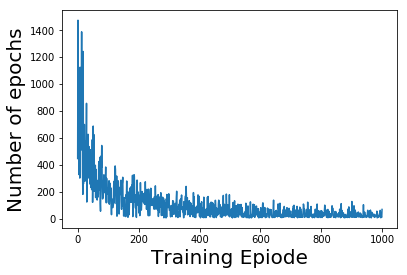

In [15]:
# Q table keeps a table of value of actions. 
# Bonus question: What's the difference between Q value and reward?

q_table= np.zeros([env.observation_space.n, env.action_space.n])
n_train=1001
frames, all_epochs=[],[]

for i in tqdm(range(1,n_train)): # training episodes
    
    # reset to a random state
    state=env.reset()
    
    # init vars
    epochs, penalties, reward = 0, 0, 0
    
    done=False
    while not done: # use epochs
        
        # select action: explore or exploit?
        action=0
        action=select_action(env, epsilon)
        
        # take action, get outcome
        next_state, reward, done, info=env.step(action)
        
        # $$$ update new value $$$
        old_value=q_table[state, action]
        next_max = np.max(q_table[next_state])                
        new_value = (1-alpha)*old_value+alpha*(reward+gamma*next_max)
        q_table[state, action]=new_value
        
        # oh oh
        if reward==-10: # illegal action
            penalties +=1
        
        # advance to next state
        state=next_state
        epochs+=1
        
        # save for plots
        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward':reward
        })
    #frames_f(frames)
    #sleep(.1)
    #print('epochs: {}'.format(epochs))
    all_epochs.append(epochs)
    if i % 100==0:
        sleep(.1)
        clear_output(wait=True)
        print("Episode: {}".format(i))
        
print("Training is Done.")

#######
plt.plot(all_epochs) 
plt.ylabel('Number of epochs', fontsize=20)
plt.xlabel('Training Epiode', fontsize=20)



# Compare random action vs. Q-learning 

Now we can ompare the result of selecting random actions, which can sometimes be rewarding, versus the Q-learning approach above. But to be fair, let's allow our random policy rival company to have its taxi experience a 1000 episodes too.

100%|██████████| 1000/1000 [00:25<00:00, 37.84it/s]

Done.


Text(0.5, 0, 'Training Epiode')

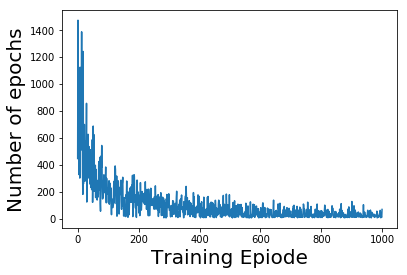

In [16]:
# take a random action approach 
penalties, reward= 0, 0
all_epochs_rand=[]
for i in tqdm(range(1,n_train)):
    epochs=0
    done=False
    while not done:
        # sample a random action
        action=env.action_space.sample()
        # step the agent and get reward with that action
        state, reward, done, info = env.step(action)
        # wrong move?
        if reward ==-10:
            penalties+=1
        epochs+=1
    all_epochs_rand.append(epochs)
    
print('Done.')

plt.plot(all_epochs) 
plt.ylabel('Number of epochs', fontsize=20)
plt.xlabel('Training Epiode', fontsize=20)

Text(0.5, 0, 'Q-Learning')

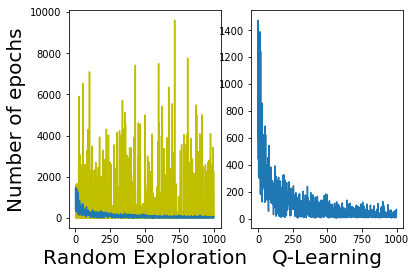

In [31]:
plt.subplot(1,2,1)
plt.plot(all_epochs_rand, 'y')
plt.plot(all_epochs)
plt.ylabel('Number of epochs', fontsize=20)
plt.xlabel('Random Exploration', fontsize=20)
plt.subplot(1,2,2)
plt.plot(all_epochs)
plt.xlabel('Q-Learning', fontsize=20)



Yellow is random, blue is Q-learning. I plotted them together on the left so you can really compare! See that little blue thing below the random epochs? yeah that's how long Q learning takes. On the right you can see it zoomed in. No wonder insects and mammals don't just randomly move in the world bumping into things (mostly), costs are high. Oh and Q learning is not even the best RL game in town!


# Nicely done :) See if you can answer these questions: 


What's the difference between 1000 episodes of random trial and error and 1000 episodes of learning the value of action and doing some trial and error?

What are alpha, gamma, and epsilon?

Can you write the equation for Q learning?

When is it optimal to explore more? 

Is there something in this code you can apply to a probelm you're interested in? 

Here we used a simple example from Open AI GYM. I challenge you to make an environment (it's super simple really!) on your own. Taxi is too much, make a simple T maze, put reward on left or right. I'll help :) 


# You're ready for the next notebook!